In [8]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
import pickle

In [10]:
df = pd.read_csv("data.csv")

# EDA

In [14]:
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

Since there is no missing value and the data type is already true then we do not need to preprocess it.

In [16]:
df.duplicated().any()

False

## Feature engineering (Change date into numeric columns)

In [17]:
def parse_date(date):
    return date[:10]

In [18]:
df['date'] = df['date'].apply(parse_date)

In [19]:
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [20]:
df.date.unique()

array(['2014-05-02', '2014-05-03', '2014-05-04', '2014-05-05',
       '2014-05-06', '2014-05-07', '2014-05-08', '2014-05-09',
       '2014-05-10', '2014-05-11', '2014-05-12', '2014-05-13',
       '2014-05-14', '2014-05-15', '2014-05-16', '2014-05-17',
       '2014-05-18', '2014-05-19', '2014-05-20', '2014-05-21',
       '2014-05-22', '2014-05-23', '2014-05-24', '2014-05-25',
       '2014-05-26', '2014-05-27', '2014-05-28', '2014-05-29',
       '2014-05-30', '2014-05-31', '2014-06-01', '2014-06-02',
       '2014-06-03', '2014-06-04', '2014-06-05', '2014-06-06',
       '2014-06-07', '2014-06-08', '2014-06-09', '2014-06-10',
       '2014-06-11', '2014-06-12', '2014-06-13', '2014-06-14',
       '2014-06-15', '2014-06-16', '2014-06-17', '2014-06-18',
       '2014-06-19', '2014-06-20', '2014-06-21', '2014-06-22',
       '2014-06-23', '2014-06-24', '2014-06-25', '2014-06-26',
       '2014-06-27', '2014-06-28', '2014-06-29', '2014-06-30',
       '2014-07-01', '2014-07-02', '2014-07-03', '2014-

the format of the date is yyyy-mm-dd

In [21]:
df['date'] = df['date'].apply(pd.to_datetime)

In [22]:
df['listed day'] = df['date'].dt.day
df['listed month'] = df['date'].dt.month
df['listed year'] = df['date'].dt.year
df.drop('date', axis = 1, inplace = True)

In [23]:
df['listed year'].nunique()

1

listed year column only contains 1 unique value, hence it will be dropped because no inforomation can be gained from this column

In [24]:
df.drop('listed year', axis = 1, inplace = True)

In [25]:
cat = []
num = []

for col in df.columns:
    if df[col].dtype ==  'O':
        cat.append(col)
    else:
        num.append(col)

In [26]:
df[cat].describe()

,street,city,statezip,country
count,4600,4600,4600,4600
unique,4525,44,77,1
top,2520 Mulberry Walk NE,Seattle,WA 98103,USA
freq,4,1573,148,4600


Country contains only 1 unique value, because there is no information that can be gained for the model, we will drop this column

In [27]:
df.drop('country', axis = 1, inplace = True)

In [28]:
df[num].describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,listed day,listed month
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,14.791304,5.757609
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,8.677569,0.683851
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,1.000000,5.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,7.000000,5.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,14.000000,6.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000,23.000000,6.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,31.000000,7.000000


In [29]:
df[num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  listed day     4600 non-null   int64  
 14  listed month   4600 non-null   int64  
dtypes: float64(4), int64(11)
memory usage: 539.2 KB


In [30]:
cat = []
num = []

for col in df.columns:
    if df[col].dtype ==  'O':
        cat.append(col)
    else:
        num.append(col)

## Univariate analysis

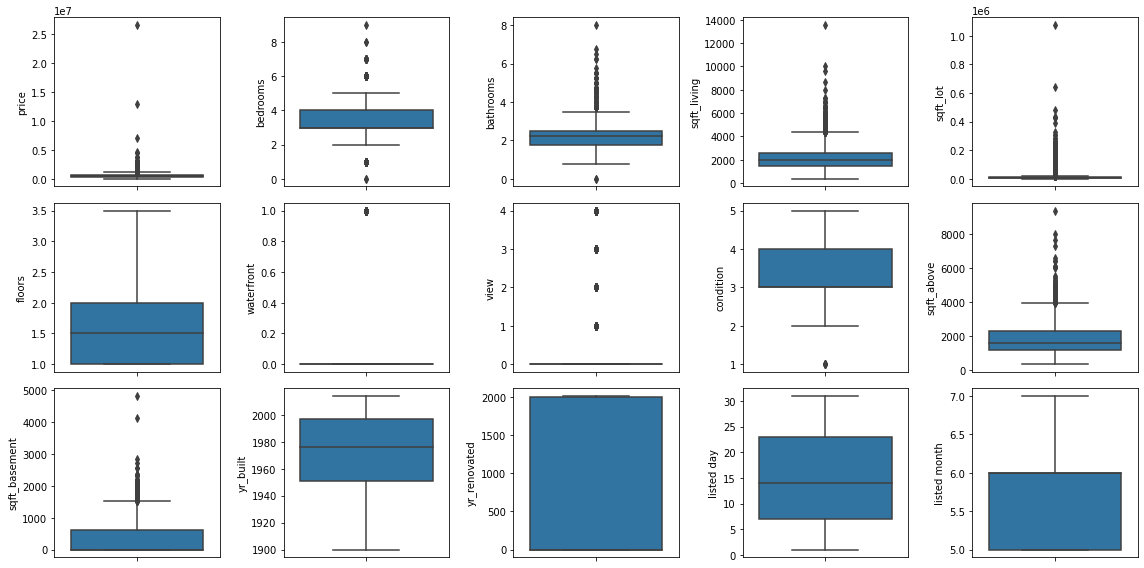

In [31]:
plt.figure(figsize = (16,8))
for i in range(len(num)):
    plt.subplot(3, round(len(num)/3), i+1)
    sns.boxplot(y = df[num[i]], orient = 'v')
    plt.tight_layout()

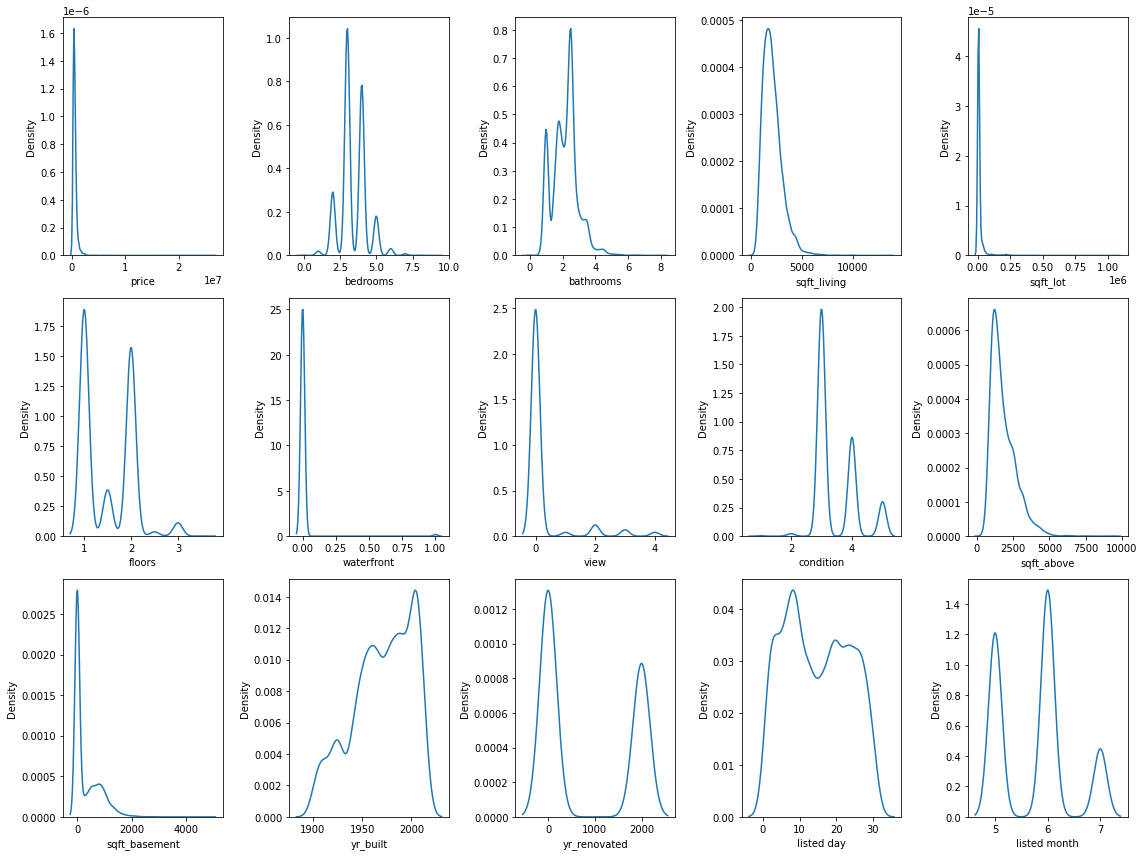

In [32]:
plt.figure(figsize = (16,12))
for i in range(len(num)):
    plt.subplot(3, round(len(num)/3), i+1)
    sns.kdeplot(x = df[num[i]])
    plt.tight_layout()

price, sqft_living, sqft_lot, sqft_above, sqft_basement has right-skewed distribution, hence we will use box-cox transformation for these columns later in the pre-processing.

In [33]:
cat

['street', 'city', 'statezip']

In [34]:
df[cat].describe()

,street,city,statezip
count,4600,4600,4600
unique,4525,44,77
top,2520 Mulberry Walk NE,Seattle,WA 98103
freq,4,1573,148


In [35]:
df['street'].value_counts()[df['street'].value_counts() >= 2]

2520 Mulberry Walk NE     4
2500 Mulberry Walk NE     3
9413 34th Ave SW          2
6008 8th Ave NE           2
11034 NE 26th Pl          2
                         ..
34214 SE Carmichael St    2
23017 SE 281st Ct         2
19454 SE 27th Pl          2
2358 Fairview Ave E       2
5703 Charlotte Ave SE     2
Name: street, Length: 72, dtype: int64

We can see that the column street has too many unique values and each values contain only miniscule value. This can be seen by looking at the value distribution of each street, there are only 72 street with the value bigger than 2. Therefore, this column cannot be used because the huge amount of unique values it has will trigger curse of dimensionality.

In [36]:
df.drop('street', axis = 1, inplace = True)

In [37]:
def mutual_information(df,y):
    df = df.copy()
    df.drop('price', axis = 1, inplace = True)
    cat = []
    num = []

    for col in df.columns:
        if df[col].dtype ==  'O':
            cat.append(col)
        else:
            num.append(col)
    
    for col in cat:
        df[col], _ = df[col].factorize()
        
    mi_score = mutual_info_regression(df,y,discrete_features=[False if x == "price" else True for x in df.columns],random_state=42)
    mi_score = pd.Series(mi_score,name='Mutual Information Score',index=df.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [38]:
mi = mutual_information(df, df['price'])
mi

statezip         0.456556
city             0.310017
sqft_living      0.298320
sqft_above       0.200541
bathrooms        0.176452
sqft_lot         0.146766
bedrooms         0.076072
yr_built         0.075932
floors           0.062533
view             0.052856
sqft_basement    0.045654
yr_renovated     0.015471
condition        0.006781
waterfront       0.006543
listed day       0.000000
listed month     0.000000
Name: Mutual Information Score, dtype: float64

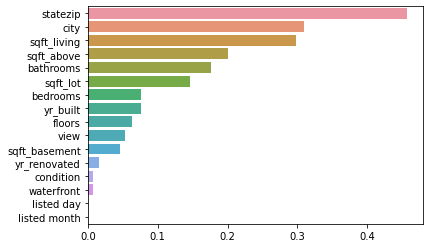

In [39]:
sns.barplot(x = mi.values, y = mi.index);

From the mutual information above we can see that listed day and listed month are independent to our target variable, possibly it will be removed. On the other hand, the target are dependant on street, statezip, and city so we should keep this variable although they have high cardinality.

In [40]:
cat = []
num = []

for col in df.columns:
    if df[col].dtype ==  'O':
        cat.append(col)
    else:
        num.append(col)

## Multivariate analysis

In [41]:
df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip,listed day,listed month
0,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA 98133,2,5
1,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,WA 98119,2,5
2,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,WA 98042,2,5


In [42]:
num

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'listed day',
 'listed month']

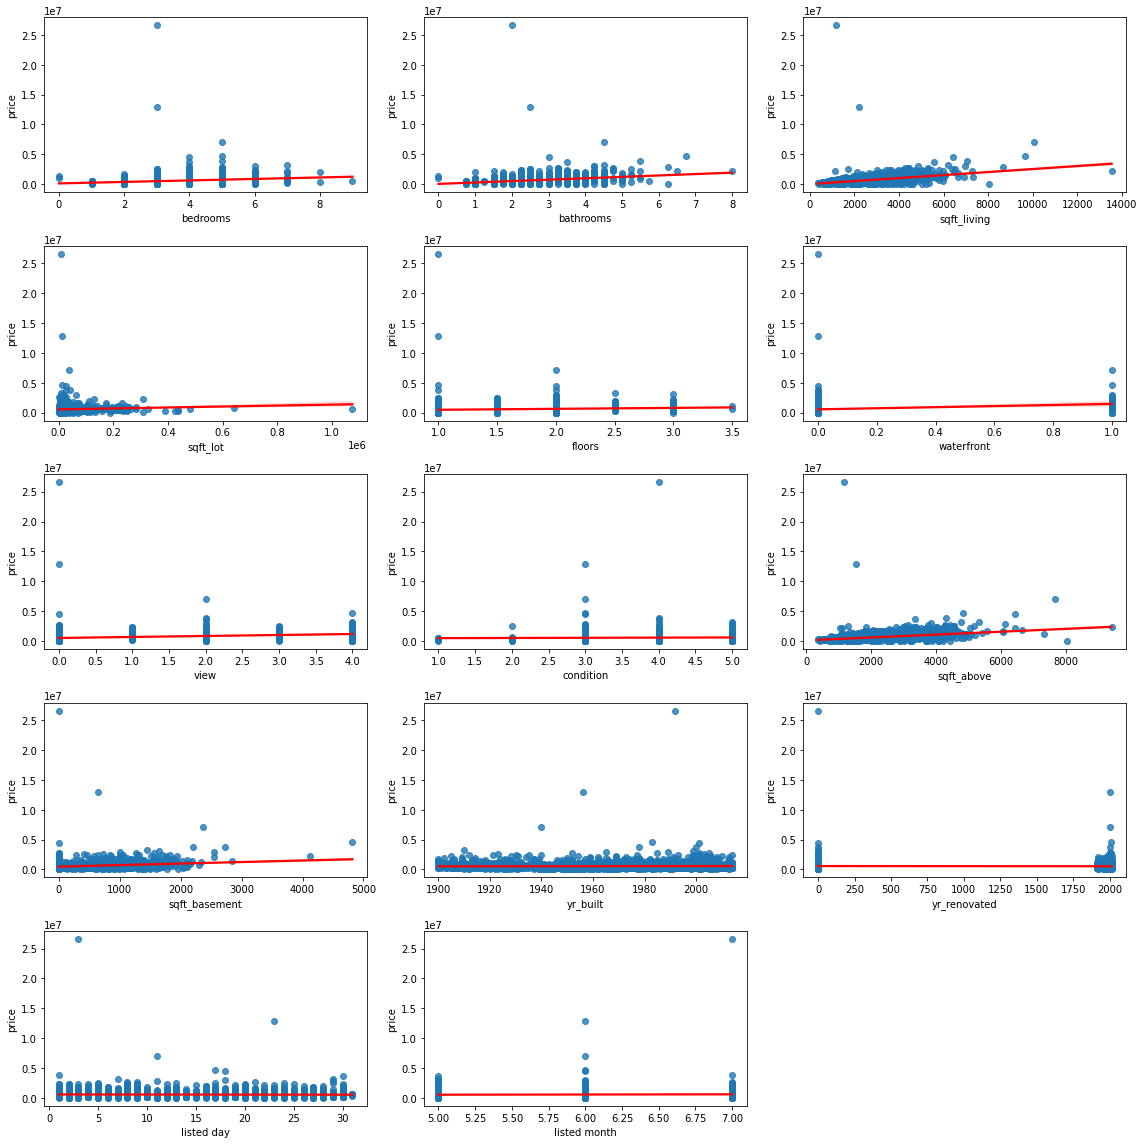

In [43]:
plt.figure(figsize = (16,16))
for i in range(1,len(num)):
    plt.subplot(5, round(len(num)/5), i)
    sns.regplot(x = num[i], y = 'price', data = df, line_kws={"color": "red"})
    plt.tight_layout()

We can see in the yr_renovated, it is 0 when the house is never been renovated. instead of 0 we will change it into the yr_built because we want to minimize the difference between the one that is renovated and not and instead focus on when was the last time the house was renovated

In [44]:
def renov(yr_renovated, yr_built):
    if yr_renovated == 0:
        return yr_built
    else:
        return yr_renovated

In [45]:
df['yr_renovated'] = df.apply(lambda x: renov(x['yr_renovated'], x['yr_built']), axis = 1)

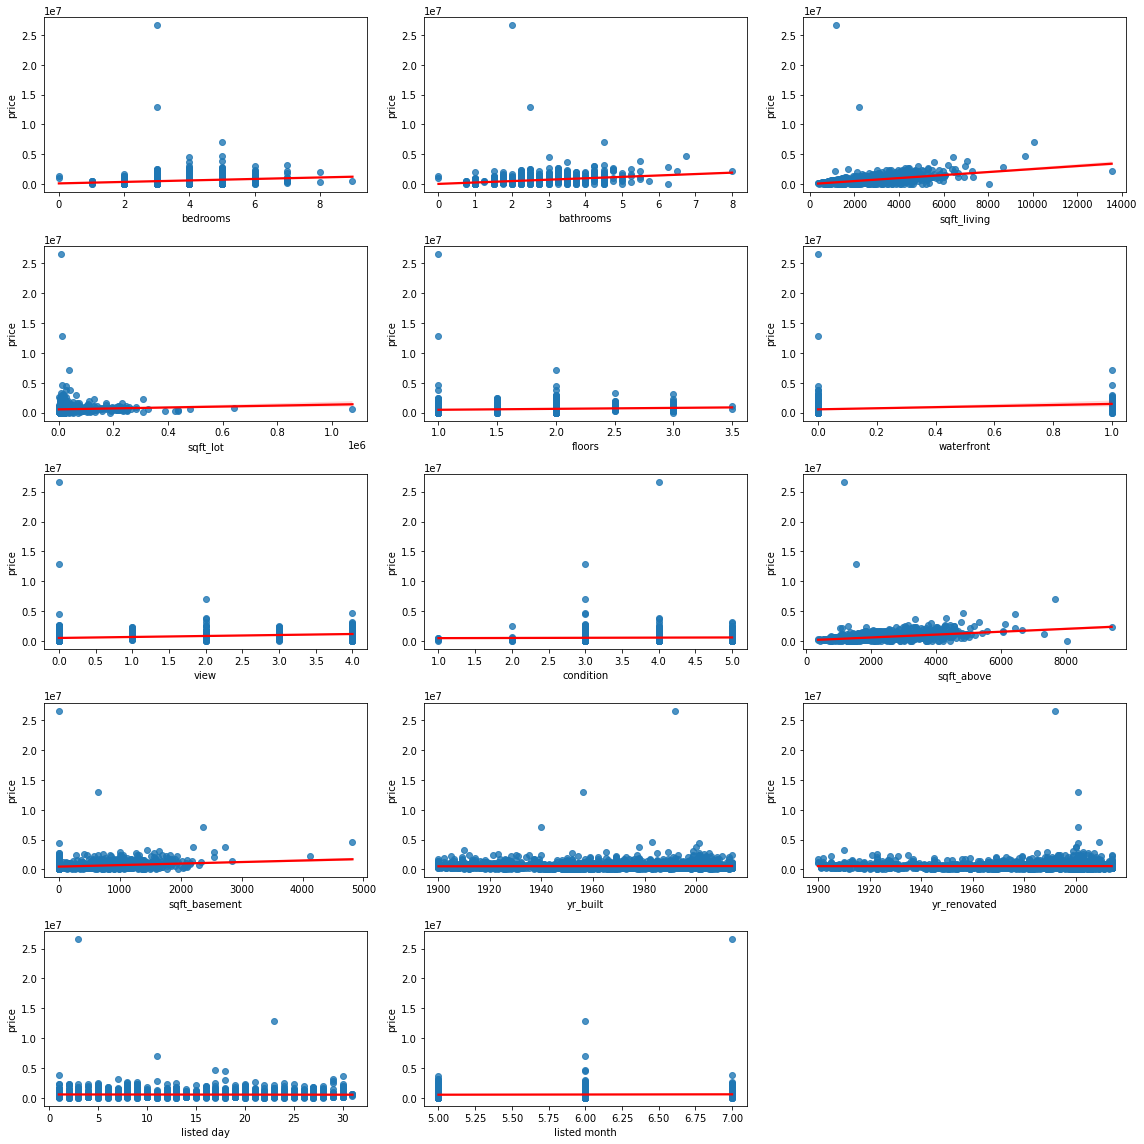

In [46]:
plt.figure(figsize = (16,16))
for i in range(1,len(num)):
    plt.subplot(5, round(len(num)/5), i)
    sns.regplot(x = num[i], y = 'price', data = df, line_kws={"color": "red"})
    plt.tight_layout()

Here we can see some outlier, like those with the price above 10 million

In [47]:
df[df['price'] > 1e7]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip,listed day,listed month
4346,12899000.0,3.0,2.5,2190,11394,1.0,0,0,3,1550,640,1956,2001,Seattle,WA 98199,23,6
4350,26590000.0,3.0,2.0,1180,7793,1.0,0,0,4,1180,0,1992,1992,Kent,WA 98031,3,7


All of the outlier will be removed in the preprocessing using Z-score

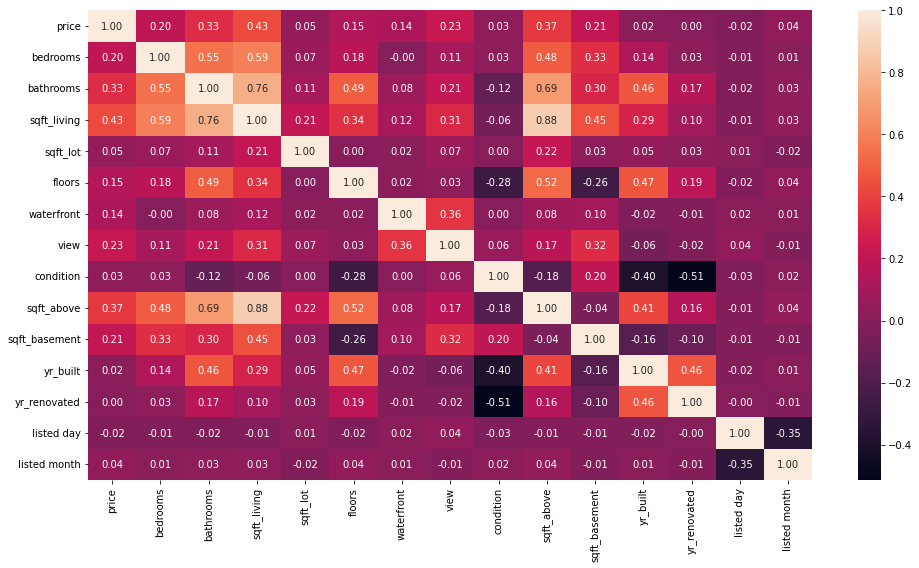

In [48]:
plt.figure(figsize = (14,8))
sns.heatmap(df.corr(), annot = True, fmt = '.2f')
plt.tight_layout()

sqft_lot, condition, yr_built, yr_renovated, listed_day and listed_month have small correlation with the target feature (price). But we will not drop it for now, but will be considerated if the model has bad performance

In [49]:
df[['sqft_living', 'sqft_above', 'sqft_basement']]

,sqft_living,sqft_above,sqft_basement
0,1340,1340,0
1,3650,3370,280
2,1930,1930,0
3,2000,1000,1000
4,1940,1140,800
...,...,...,...
4595,1510,1510,0
4596,1460,1460,0
4597,3010,3010,0
4598,2090,1070,1020


As we can see sqft_living and sqft_above columns is highly correlated and from the data we can see that in some houses the value is the same. this is because sqft_living is the sum of sqft_above and sqft_basement, so houses with no basement have the same value for sqft_living and sqft_above. Hence, we will drop sqft_living because it is redundant and will cause multicolinearity

In [50]:
df.drop('sqft_living', axis = 1, inplace = True)

In [51]:
df.head(3)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip,listed day,listed month
0,313000.0,3.0,1.5,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA 98133,2,5
1,2384000.0,5.0,2.5,9050,2.0,0,4,5,3370,280,1921,1921,Seattle,WA 98119,2,5
2,342000.0,3.0,2.0,11947,1.0,0,0,4,1930,0,1966,1966,Kent,WA 98042,2,5


In [52]:
df.shape

(4600, 16)

# Preprocessing

## Import Library

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from category_encoders import MEstimateEncoder
from category_encoders import TargetEncoder

In [54]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,listed day,listed month
count,4.600000e+03,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,1985.042609,14.791304,5.757609
std,5.638347e+05,0.908848,0.783781,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,26.863922,8.677569,0.683851
min,0.000000e+00,0.000000,0.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,1900.000000,1.000000,5.000000
25%,3.228750e+05,3.000000,1.750000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,1973.000000,7.000000,5.000000
50%,4.609435e+05,3.000000,2.250000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,1994.000000,14.000000,6.000000
75%,6.549625e+05,4.000000,2.500000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,2005.000000,23.000000,6.000000
max,2.659000e+07,9.000000,8.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,31.000000,7.000000


## Things to do

- Handle outlier using Z-score
- Split training and unseen data (test data), no valid_data needed because we will use CV instead
- Boxcox transform: sqft_living, sqft_lot, sqft_above, sqft_basement

## Remove Outlier

In [55]:
cat = []
num = []

for col in df.columns:
    if df[col].dtype ==  'O':
        cat.append(col)
    else:
        num.append(col)

In [56]:
outlier = num.copy()
outlier

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'listed day',
 'listed month']

In [57]:
outlier.remove('listed day') #discrete
outlier.remove('listed month') #discrete
outlier.remove('waterfront') #discrete
outlier.remove('condition') #discrete

In [58]:
print(f'rows before filtering the outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in outlier:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries 
    
df_filter = df[filtered_entries] 

print(f'rows after filtering the outlier: {len(df_filter)}')

rows before filtering the outlier: 4600
rows after filtering the outlier: 4216


### Before Outlier Removal

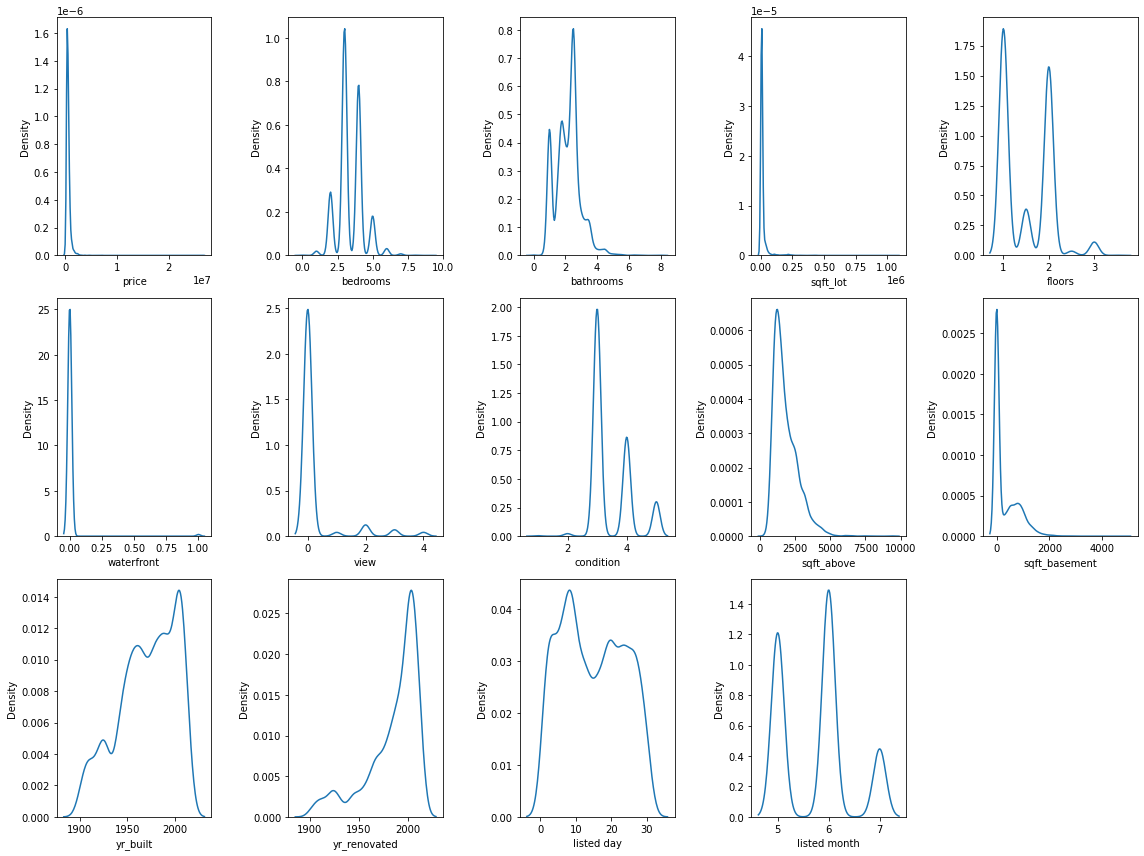

In [59]:
plt.figure(figsize = (16,12))
for i in range(len(num)):
    plt.subplot(3, round(len(num)/3), i+1)
    sns.kdeplot(x = df[num[i]])
    plt.tight_layout()

### After Outlier Removal

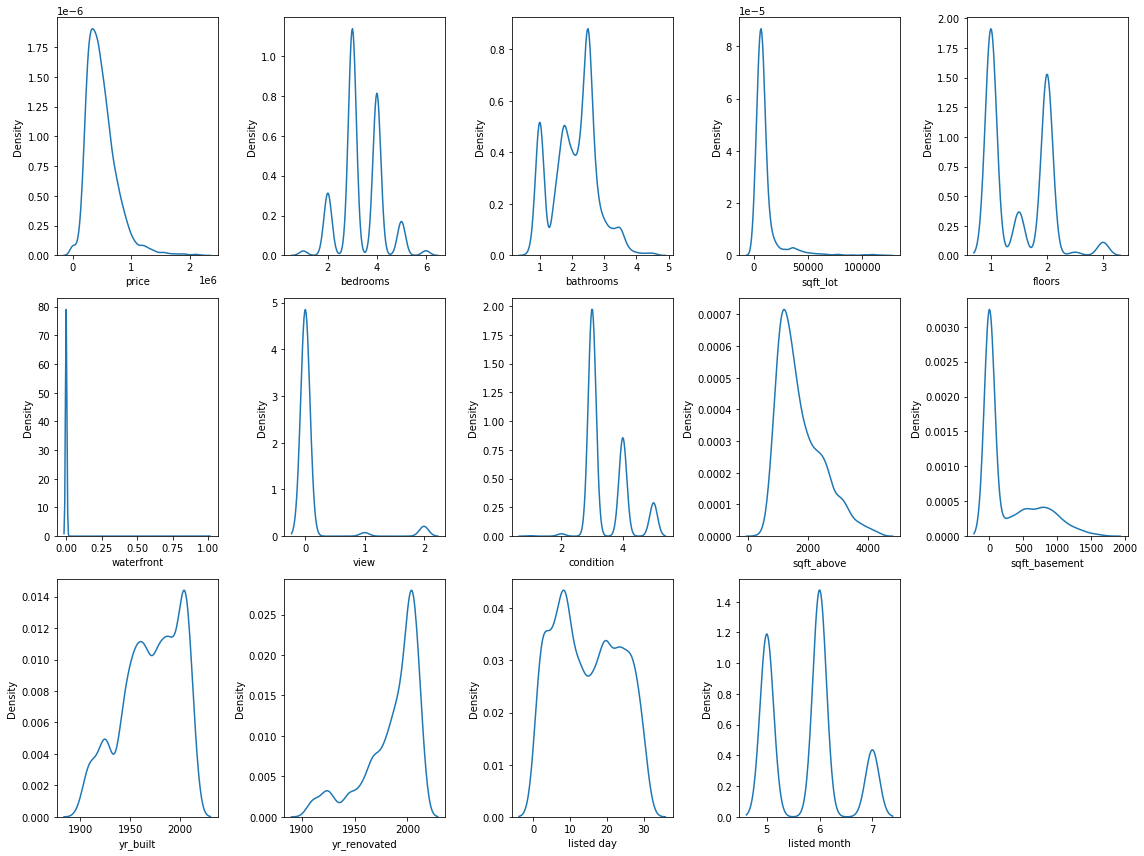

In [60]:
plt.figure(figsize = (16,12))
for i in range(len(num)):
    plt.subplot(3, round(len(num)/3), i+1)
    sns.kdeplot(x = df_filter[num[i]])
    plt.tight_layout()

## Splitting data

In [61]:
df1 = df_filter.copy()

# other_city = df1['city'].value_counts()[df1['city'].value_counts() < 20].index.to_list()
# other_statezip = df1['statezip'].value_counts()[df1['statezip'].value_counts() < 20].index.to_list()

# df1.loc[df1['city'].isin(other_city), 'city'] = "others"
# df1.loc[df1['statezip'].isin(other_statezip), 'statezip'] = "others"

We have tried using target encoder for columns "city" and "statezip" to keep the dimension of data so curse of dimensionality can be avoided; However, the result are not satisfactory. Therefore, our last resort is to use the one hot encoding because these two features are important for the target.

## One-hot Encoding

In [62]:
tbEncoded = df1[['city', 'statezip']].copy()

OHencoder = OneHotEncoder(sparse = False).fit(tbEncoded)
asd = pd.DataFrame(OHencoder.transform(tbEncoded))

df1 = df1.reset_index(drop = True).join(asd)

In [63]:
# df1 = pd.get_dummies(df1, columns = ['city', 'statezip'])

In [64]:
X = df1.drop(['price', 'city', 'statezip'], axis = 1)
# X = df1.drop(['price'], axis = 1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Transformation

- boxcox transoformation : sqft_lot, sqft_above, sqft_basement
- left skewed: yr_built, yr_renovated

In [65]:
X_train_transform = X_train.copy()
X_test_transform = X_test.copy()

In [66]:
log_col = ['sqft_lot', 'sqft_basement']

In [67]:
# log_col = ['sqft_lot', 'sqft_basement']

# X_train_transform.loc[X_train_transform["sqft_basement"] == 0, 'sqft_basement'] =  0.01
# X_test_transform.loc[X_test_transform["sqft_basement"] == 0, 'sqft_basement'] =  0.01

# def boxcox_transform(val):
#     return stats.boxcox(val)[0]

# X_train_transform[log_col] = X_train_transform[log_col].apply(boxcox_transform)

## Normalization

In [68]:
X_train_norm = X_train_transform.copy()
X_test_norm = X_test_transform.copy()

cat = []
num = []

for col in X_train.columns:
    if X_train[col].dtype ==  'O':
        cat.append(col)
    else:
        num.append(col)


In [69]:
num = [
    'bedrooms',
    'bathrooms',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'yr_renovated',
    'listed day',
    'listed month']

In [71]:
scaler = MinMaxScaler().fit(X_train_norm[num])
X_train_norm[num] = scaler.transform(X_train_norm[num])
X_test_norm[num] = scaler.transform(X_test_norm[num])

In [72]:
X_train = X_train_norm
X_test = X_test_norm

In [74]:
X_train

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,...,111,112,113,114,115,116,117,118,119,120
4096,0.6,0.400000,0.057172,0.50,0.0,0.0,0.75,0.419355,0.000000,0.675439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1553,0.2,0.066667,0.034693,0.00,0.0,0.0,0.50,0.151365,0.000000,0.412281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222,0.4,0.200000,0.006132,1.00,0.0,0.0,0.50,0.217122,0.000000,0.912281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
736,0.4,0.333333,0.014681,0.25,0.0,0.0,0.50,0.265509,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2627,0.4,0.266667,0.061880,0.00,0.0,0.0,0.75,0.230769,0.000000,0.421053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.4,0.333333,0.028611,0.25,0.0,0.0,1.00,0.200993,0.000000,0.061404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,0.4,0.066667,0.047841,0.00,0.0,0.0,0.50,0.094293,0.129412,0.359649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3092,0.8,0.400000,0.123926,0.50,0.0,0.0,0.75,0.493797,0.000000,0.710526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,0.2,0.333333,0.033552,0.00,0.0,0.0,0.50,0.295285,0.000000,0.929825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [75]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

In [76]:
LR = LinearRegression()
LR.fit(X_train, y_train)
print("Train Score:")
y_pred_train = LR.predict(X_train)
print("r2:", r2_score(y_train, y_pred_train))
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))

y_pred = LR.predict(X_test)
print("Test Score:")
print("r2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))

Train Score:
r2: 0.7242013726007294
MAE: 83076.18285161802
RMSE: 142036.76284055
Test Score:
r2: 0.7763472777593414
MAE: 79663.85726202725
RMSE: 117658.85453398305


In [69]:
models = [DecisionTreeRegressor(random_state = 42),
          KNeighborsRegressor(),
          SVR(),
         RandomForestRegressor(random_state = 42),
         GradientBoostingRegressor(random_state = 42),
         XGBRegressor(random_state = 42, use_label_encoder=False),
         AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 16.0, max_features = 9, min_samples_leaf= 1, min_samples_split=2, random_state = 469), random_state = 42),
         CatBoostRegressor(random_state = 42, verbose = False)]
names = ['Decision Tree',
         'KNN',
         'SVM',
       'Random Forest',
       'Gradient Boosting',
       'XGBoost',
       'AdaBoost',
       'CatBoost']

## Before Hyperparameter Tuning

In [70]:
def model_score(model, name):
    print(f'{name}:')
    model = model
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    print("Train score:")
    print("r2:", r2_score(y_train, y_pred_train))
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))
    print('Test score:')
    y_pred = model.predict(X_test)
    print("r2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))
    print('\n')

In [98]:
# X_train, X_test = X_train_norm, X_test_norm

In [399]:
for i in range(len(models)):
    model_score(models[i], names[i])

Decision Tree:
Train score:
r2: 1.0
MAE: 0.0
RMSE: 0.0
Test score:
r2: 0.2698274665273497
MAE: 126734.15204079858
RMSE: 212593.63994692883


KNN:
Train score:
r2: 0.5301857989333343
MAE: 128007.6271834121
RMSE: 185382.0948889408
Test score:
r2: 0.3805232366551655
MAE: 143366.32901206327
RMSE: 195816.8373467799


SVM:
Train score:
r2: -0.03529361049575175
MAE: 192585.9238339662
RMSE: 275192.42950556474
Test score:
r2: -0.028526253744582064
MAE: 185400.77097784696
RMSE: 252316.24486270463


Random Forest:
Train score:
r2: 0.9497306535244476
MAE: 35800.514993890916
RMSE: 60639.6010140638
Test score:
r2: 0.7266631051778629
MAE: 84368.59328420922
RMSE: 130072.84814178039


Gradient Boosting:
Train score:
r2: 0.768653422167779
MAE: 86382.64859896083
RMSE: 130087.7060115735
Test score:
r2: 0.7251568409726274
MAE: 90487.44505490336
RMSE: 130430.74878161051


XGBoost:
Train score:
r2: 0.9653400479872203
MAE: 35240.33684841592
RMSE: 50352.2282273774
Test score:
r2: 0.7333700726134337
MAE: 80932.

## After Hyperparameter Tuning

In [71]:
def plusNone(arr):
    return np.array(arr.tolist() + [None])

In [72]:
params = [
    { # Decision Tree
        'max_depth': plusNone(np.linspace(1, 32, 32, endpoint=True)),
        'min_samples_split': list(range(0,10)),
        'min_samples_leaf': list(range(0,10)),
        'max_features': plusNone(np.array(range(1,X_train.shape[1])))
    },
    { # KNearestNeighbor
        'leaf_size': list(range(1,50)),
        'n_neighbors': list(range(1,30)),
        'p': [1,2],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    {# SVC
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }, 
    {#Random Forest
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    },
    {# Gradient Boosting
        "n_estimators":[5,50,250,500],
        "max_depth":[1,3,5,7,9],
        "learning_rate":[0.01,0.1,1,10,100]
    },
    { # XGBoost
#         'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 5)],
        'gamma' : [float(x) for x in np.linspace(0, 1, num = 5)],
        'tree_method' : ['auto', 'exact', 'approx', 'hist'],

        'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 5)],
        'eta' : [float(x) for x in np.linspace(0, 1, num = 10)],

        'lambda' : [float(x) for x in np.linspace(0, 1, num = 5)],
        'alpha' : [float(x) for x in np.linspace(0, 1, num = 5)]
    },
    { # Adaboost
       'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
       'learning_rate': [float(x) for x in np.linspace(start = 0.001, stop = 1, num = 20)],
#        'algorithm': ['SAMME', 'SAMME.R']
    },
    {# Catboost
        'max_depth': [3,4,5],
        'n_estimators':[100, 200, 300]
    }
]

In [73]:
def model_score_tune_rscv(i, n_iter = 10, verbose = 0):
    model = models[i]
    name = names[i]
    param = params[i]
    
    
    print(f'{name}:')
    RSCV = RandomizedSearchCV(model, param, cv = 2, n_jobs = -1, verbose = verbose, random_state = 42, n_iter = n_iter, scoring = "r2")
    RSCV.fit(X_train, y_train)
    y_pred_train = RSCV.predict(X_train)
    print("Train score:")
    print("r2:", r2_score(y_train, y_pred_train))
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))
    print('Test score:')
    y_pred = RSCV.predict(X_test)
    print("r2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))
    print('\n')
    print(RSCV.best_params_)
    print('\n')

In [441]:
for i in range(len(models)):
    model_score_tune_rscv(i, n_iter = 100)

Decision Tree:
Train score:
r2: 0.6491769048401121
MAE: 112825.19897283937
RMSE: 160194.9434370979
Test score:
r2: 0.45322440995712987
MAE: 128366.62141738426
RMSE: 183967.9125980243


{'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 96, 'max_depth': 8.0}


KNN:
Train score:
r2: 0.40929817520443135
MAE: 141769.594861605
RMSE: 207868.59075301213
Test score:
r2: 0.4094898873490298
MAE: 138588.15553563283
RMSE: 191183.8448698368


{'p': 1, 'n_neighbors': 18, 'leaf_size': 46, 'algorithm': 'ball_tree'}


SVM:
Train score:
r2: -0.028337660286201105
MAE: 191206.12862652834
RMSE: 274266.3873674159
Test score:
r2: -0.026375550195015807
MAE: 184987.42313632517
RMSE: 252052.30341254675


{'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000}


Random Forest:
Train score:
r2: 0.9667618723765945
MAE: 26623.124322477088
RMSE: 49308.63622840105
Test score:
r2: 0.7574650359517912
MAE: 81053.20174980757
RMSE: 122524.99671321517


{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1

## Best Model

In [448]:
LR = LinearRegression()
LR.fit(X_train, y_train)
print("Train Score:")
y_pred_train = LR.predict(X_train)
print("r2:", r2_score(y_train, y_pred_train))
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))

y_pred = LR.predict(X_test)
print("Test Score:")
print("r2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))

Train Score:
r2: 0.7244226473919023
MAE: 82950.6569959689
RMSE: 141979.77296027038
Test Score:
r2: 0.7764395190487329
MAE: 79579.42536792133
RMSE: 117634.58895920898


In [452]:
par = {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1, 'random_state': 42}
model = GradientBoostingRegressor(**par)

model.fit(X_train, y_train)


print("Train Score:")
y_pred_train = model.predict(X_train)
print("r2:", r2_score(y_train, y_pred_train))
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))

y_pred = model.predict(X_test)
print("Test Score:")
print("r2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))

Train Score:
r2: 0.851108769234045
MAE: 68285.98688819513
RMSE: 104361.25076724308
Test Score:
r2: 0.767800013929969
MAE: 78899.26907294191
RMSE: 119886.04034730143


In [77]:
model = CatBoostRegressor(random_state = 42, verbose = False)
model.fit(X_train, y_train)


print("Train Score:")
y_pred_train = model.predict(X_train)
print("r2:", r2_score(y_train, y_pred_train))
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("RMSE:", mean_squared_error(y_train, y_pred_train, squared = False))

y_pred = model.predict(X_test)
print("Test Score:")
print("r2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared = False))

Train Score:
r2: 0.9204209522368948
MAE: 53325.7739291466
RMSE: 76296.40668615546
Test Score:
r2: 0.7938052985035782
MAE: 73340.80024561689
RMSE: 112973.41898402406


# Conclusion

These three models are the best model, however, we will choose CatBoostRegressor as our model compared to the others because it has higher score even though it is overfit. Furthermore, GradientBoostingRegressor also overfit and has lower score compared to the CatBoostRegressor. On the other hand, LinearRegression has underfit case, although this model is good for interpretation unlike CatBoostRegressor and GradientBoostingRegressor which are a black-box model; however, we only need the model for prediction. Therefore we will choose CatBoostRegressor as our final model.

## Export Model

In [78]:
data = {"model": model, "one-hot": OHencoder, "scaler": scaler}
with open("model_resources.pkl", "wb") as file:
    pickle.dump(data, file)

In [79]:
with open("model_resources.pkl", "rb") as file:
    data = pickle.load(file)

In [80]:
model = data['model']
OHencoder = data['one-hot']
scaler = data['scaler']